In [ ]:
!pip install kaggle

In [ ]:
mkdir -p ~/.kaggle

In [ ]:
mv /Users/macbook/Dokuments/skripsi/kaggle.json ~/.kaggle/

In [ ]:
chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

In [ ]:
!unzip fer2013.zip -d content/

In [40]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [41]:
import os

# Define your project name
project_name = 'Skripsi_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = 'content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: content/Skripsi_Emotion_Detection


In [42]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = 'content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

In [43]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = 'content/train'
test_dir = 'content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436
      happy   sad  fear  surprise  neutral  angry  disgust
test   1774  1247  1024       831     1233    958      111


<Axes: >

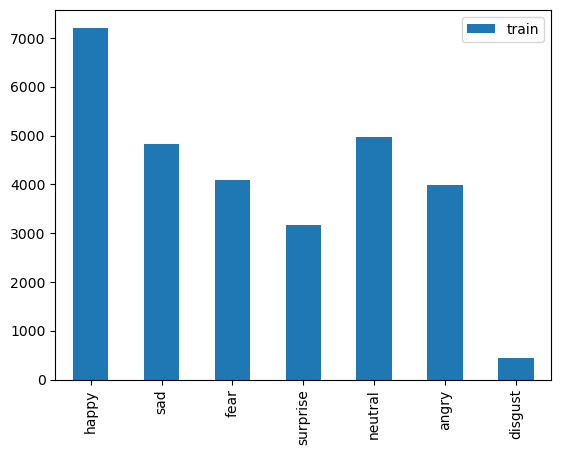

In [44]:
train_count.transpose().plot(kind='bar')

<Axes: >

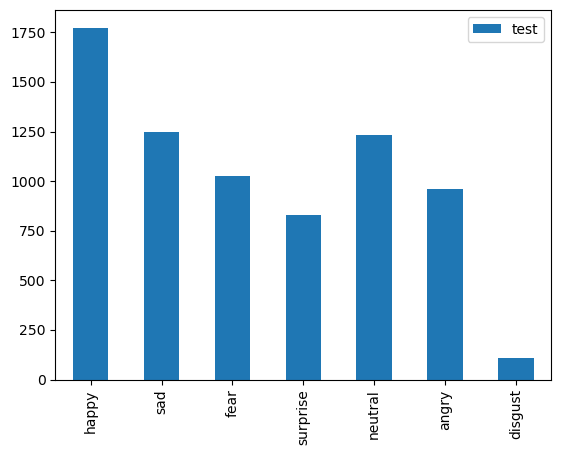

In [45]:
test_count.transpose().plot(kind='bar')

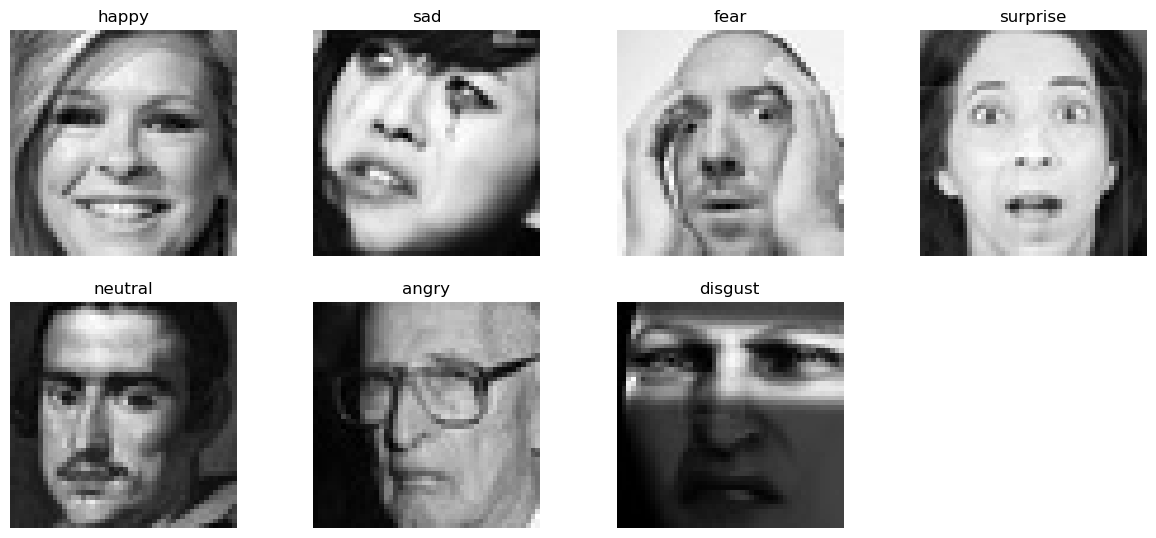

In [46]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [47]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

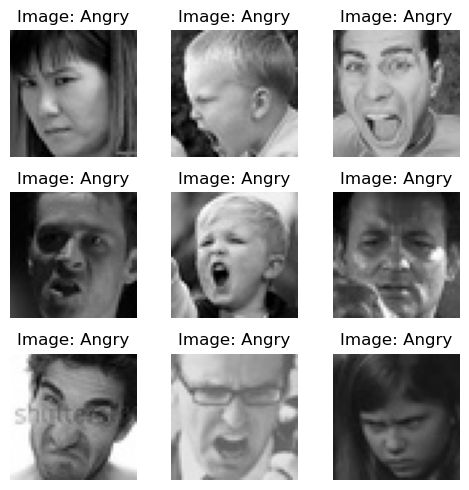

In [48]:
# Placeholder for the directory path
angry_directory_path = 'content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

In [49]:
image = 'content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


import cv2

image_path = 'content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

<h1>Model 1 : Custom CNN from Scratch</h1>

In [50]:
# Define paths to the train and validation directories
train_data_dir = 'content/train'
test_data_dir = 'content/test'

In [51]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

In [52]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [53]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [54]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/Users/macbook/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [56]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
!pip install pydot

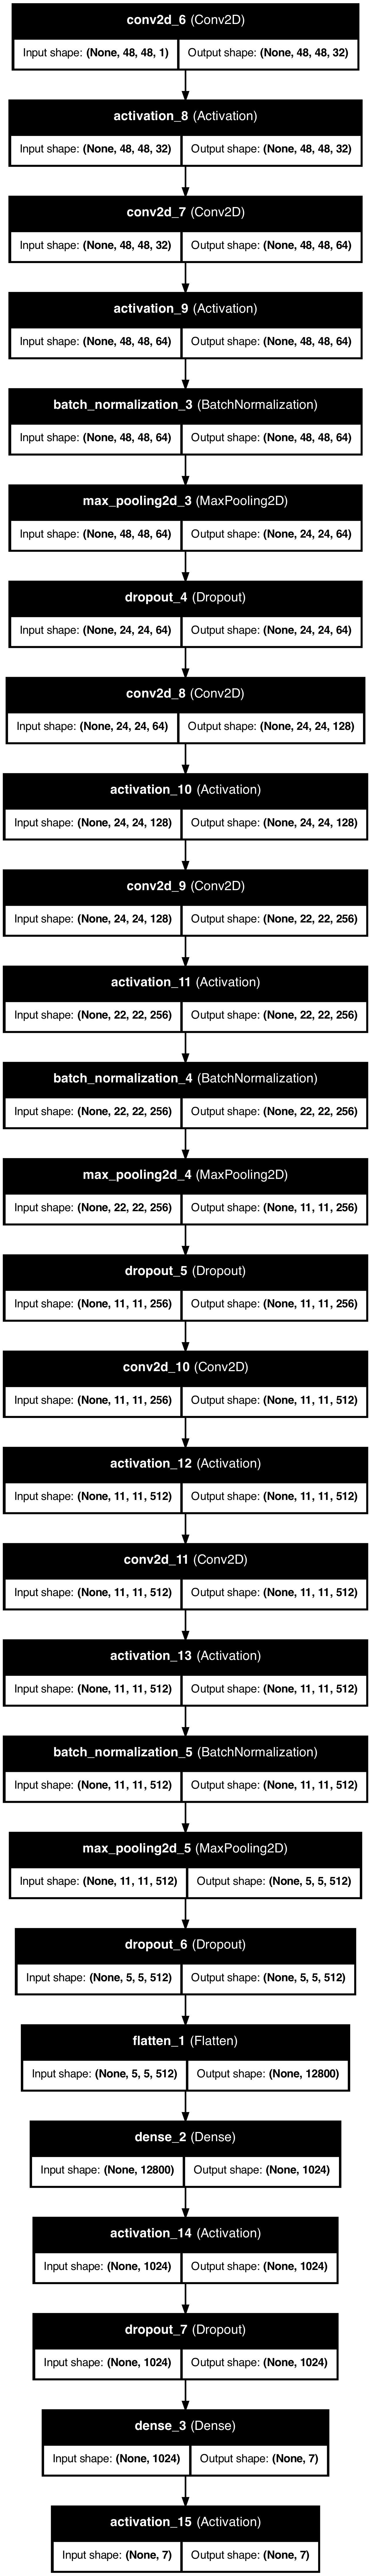

In [57]:
plot_model(model, to_file = 'content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

In [58]:
# File path for the model checkpoint
cnn_path = 'content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [59]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [60]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [61]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [62]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [63]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

In [64]:
train_generator.samples

22968

In [65]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

<h1>Model Training</h1>

In [68]:
# Adjusted calculation for validation steps
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size

# Run a test with callbacks individually to isolate issues
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

try:
    # Run a short training test
    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps_per_epoch,
        epochs=1,  # Set to 1 for quick testing
        validation_data=validation_generator,
        validation_steps=validation_steps_epoch,
        callbacks=callbacks
    )
except Exception as e:
    print("Encountered error:", e)

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3918 - loss: 8.6215
Epoch 1: val_loss improved from 9.30799 to 7.28944, saving model to content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.3918 - loss: 8.6202 - val_accuracy: 0.4208 - val_loss: 7.2894 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.


In [69]:
# Set epochs to 30 for more extended training
epochs = 30

# Updated learning rate in the optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Enhance data augmentation with additional transformations
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Use only essential callbacks initially
callbacks = [checkpoint, csv_logger]

# Calculate class weights
class_indices = train_generator.class_indices
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# Fit the model with modified parameters
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1944 - loss: 5.8840
Epoch 1: val_loss improved from 7.28944 to 2.46422, saving model to content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 765s 2s/step - accuracy: 0.1943 - loss: 5.8791 - val_accuracy: 0.1998 - val_loss: 2.4642
Epoch 2/30
  1/358 ━━━━━━━━━━━━━━━━━━━━ 11:28 2s/step - accuracy: 0.1250 - loss: 2.5503

2024-11-07 22:21:01.510657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/macbook/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 2.46422
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1250 - loss: 2.5503 - val_accuracy: 0.2667 - val_loss: 2.8412
Epoch 3/30


2024-11-07 22:21:01.979553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1150 - loss: 2.2446
Epoch 3: val_loss did not improve from 2.46422
358/358 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.1149 - loss: 2.2444 - val_accuracy: 0.1371 - val_loss: 2.7892
Epoch 4/30
  1/358 ━━━━━━━━━━━━━━━━━━━━ 13:03 2s/step - accuracy: 0.0312 - loss: 2.5016

2024-11-07 22:34:27.454789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss improved from 2.46422 to 2.33829, saving model to content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras


2024-11-07 22:34:27.880756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0312 - loss: 2.5016 - val_accuracy: 0.1333 - val_loss: 2.3383
Epoch 5/30
 99/358 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.0597 - loss: 2.1657


KeyboardInterrupt



In [70]:
# Mengatur batch size yang lebih kecil jika dataset berukuran kecil
batch_size = 32

# Memperbarui data generator
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

# Memperbaiki perhitungan steps_per_epoch
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size

# Training model dengan langkah dan batch size yang diperbarui
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Epoch 1/30


/Users/macbook/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0492 - loss: 2.3759
Epoch 1: val_loss improved from 2.33829 to 1.96031, saving model to content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 871s 1s/step - accuracy: 0.0492 - loss: 2.3757 - val_accuracy: 0.1426 - val_loss: 1.9603
Epoch 2/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 17:43 1s/step - accuracy: 0.0000e+00 - loss: 1.7222

2024-11-08 09:34:16.278748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-08 09:34:16.586661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_loss improved from 1.96031 to 1.95934, saving model to content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0000e+00 - loss: 1.7222 - val_accuracy: 0.1538 - val_loss: 1.9593
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0198 - loss: 1.9569
Epoch 3: val_loss improved from 1.95934 to 1.95066, saving model to content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 871s 1s/step - accuracy: 0.0199 - loss: 1.9569 - val_accuracy: 0.0152 - val_loss: 1.9507
Epoch 4/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 15:15 1s/step - accuracy: 0.0000e+00 - loss: 1.6789

2024-11-08 09:48:50.784870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-08 09:48:50.938155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss did not improve from 1.95066
717/717 ━━━━━━━━━━━━━━━━━━━━ 1s 299us/step - accuracy: 0.0000e+00 - loss: 1.6789 - val_accuracy: 0.0000e+00 - val_loss: 1.9518
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1108 - loss: 1.9226
Epoch 5: val_loss improved from 1.95066 to 1.94847, saving model to content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 938s 1s/step - accuracy: 0.1108 - loss: 1.9227 - val_accuracy: 0.0150 - val_loss: 1.9485
Epoch 6/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 13:34 1s/step - accuracy: 0.0312 - loss: 2.2301

2024-11-08 10:04:30.503078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-08 10:04:30.683774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 6: val_loss improved from 1.94847 to 1.94701, saving model to content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0312 - loss: 2.2301 - val_accuracy: 0.0769 - val_loss: 1.9470
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0176 - loss: 1.9622
Epoch 7: val_loss improved from 1.94701 to 1.94679, saving model to content/Skripsi_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 956s 1s/step - accuracy: 0.0176 - loss: 1.9622 - val_accuracy: 0.0152 - val_loss: 1.9468
Epoch 8/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 15:45 1s/step - accuracy: 0.0000e+00 - loss: 1.7170
Epoch 8: val_loss did not improve from 1.94679
717/717 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step - accuracy: 0.0000e+00 - loss: 1.7170 - val_accuracy: 0.0000e+00 - val_loss: 1.9480
Epoch 9/30


2024-11-08 10:20:28.735928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-08 10:20:28.861017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


234/717 ━━━━━━━━━━━━━━━━━━━━ 11:22 1s/step - accuracy: 0.0522 - loss: 1.9638

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x14dd354e0>
Traceback (most recent call last):
  File "/Users/macbook/anaconda3/lib/python3.11/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


KeyboardInterrupt: 

In [31]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

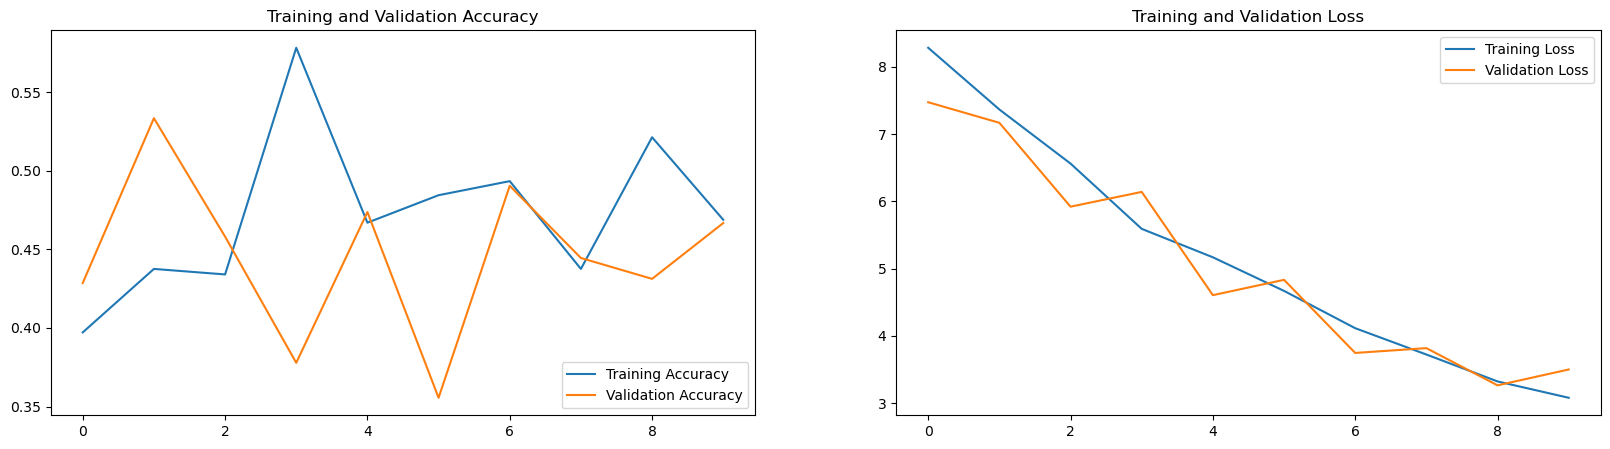

In [32]:
plot_training_history(history)

In [33]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 142s 396ms/step - accuracy: 0.4814 - loss: 3.1220
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 390ms/step - accuracy: 0.4331 - loss: 3.2468
final train accuracy = 47.79 , validation accuracy = 43.83


<h1>Plotting Confusion Matrix</h1>

113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 393ms/step


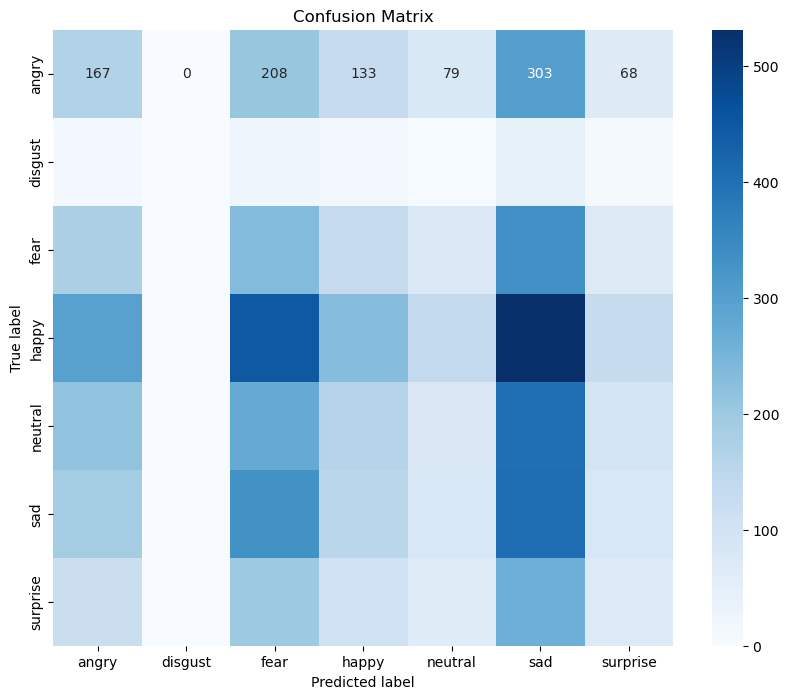

In [35]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 392ms/step


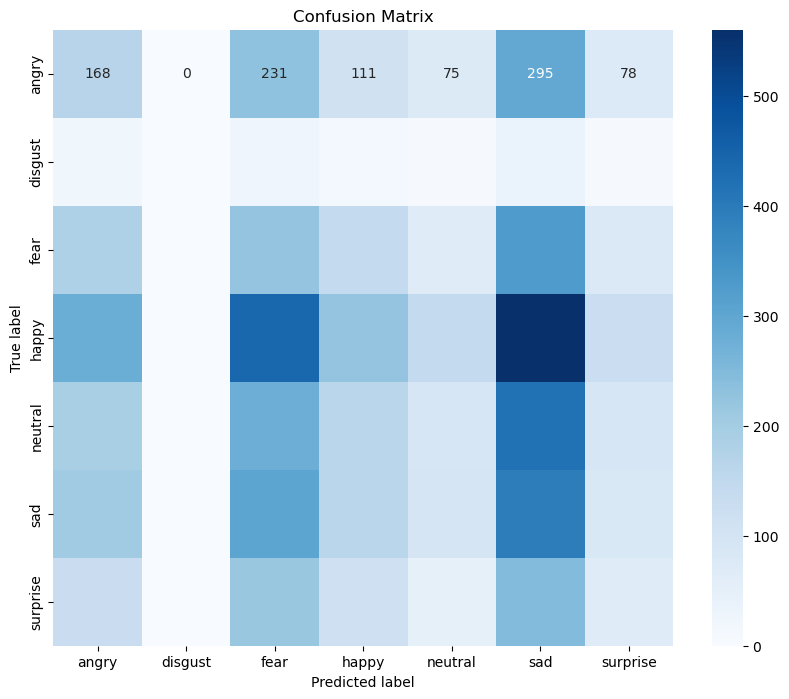

In [38]:
# Calculate the number of steps as an integer
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Get the predicted classes
predicted_classes = np.argmax(model.predict(test_generator, steps=steps), axis=1)

# Define true classes and class labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [36]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.17      0.16       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.23      0.17      1024
       happy       0.25      0.13      0.17      1774
     neutral       0.15      0.07      0.09      1233
         sad       0.18      0.32      0.23      1247
    surprise       0.14      0.09      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.16      7178

